**Import everything**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, RobustScaler, QuantileTransformer
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, train_test_split, KFold 
from sklearn.linear_model import (LinearRegression, RidgeCV, LassoCV, ElasticNetCV,
                                  BayesianRidge, RANSACRegressor, HuberRegressor)
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from scipy.special import boxcox1p
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

%matplotlib inline

**Read CSV file**

In [2]:
df_initial_train = pd.read_csv('train.csv')
df_train = df_initial_train


In [3]:
df_initial_test = pd.read_csv('test.csv')
df_test = df_initial_test
df_train = pd.concat([df_train,df_test], ignore_index=True)

**Check out the data**

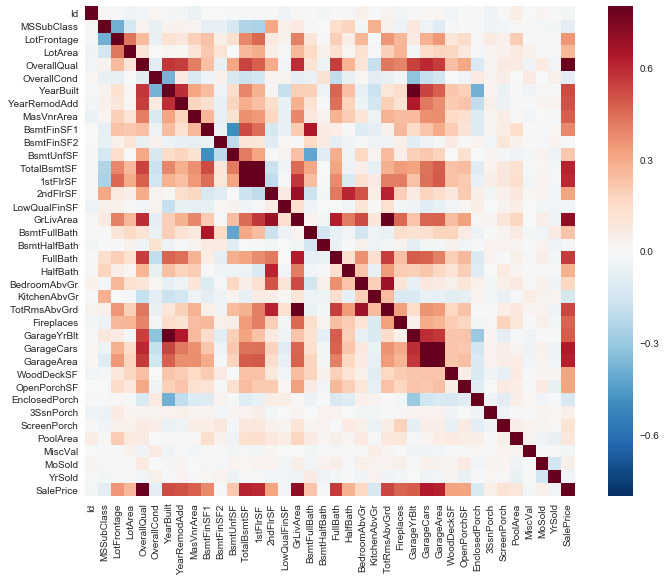

In [4]:
#correlation matrix
corrmat_initial = df_initial_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat_initial, vmax=.8, square=True);

In [5]:
#which columns have nulls
any_nulls = pd.DataFrame(df_train.isnull().sum())
any_nulls = any_nulls[any_nulls>0].dropna()

In [6]:
any_nulls

,0
Alley,2721.0
BsmtCond,82.0
BsmtExposure,82.0
BsmtFinSF1,1.0
BsmtFinSF2,1.0
BsmtFinType1,79.0
BsmtFinType2,80.0
BsmtFullBath,2.0
BsmtHalfBath,2.0
BsmtQual,81.0


**Convert Nulls**

In [7]:
# Change Lot Frontage from NA to 0
df_train.loc[:, "LotFrontage"] = df_train.loc[:, "LotFrontage"].fillna(0)
# Change Alley from NA to None
df_train.loc[:, "Alley"] = df_train.loc[:, "Alley"].fillna("None")
# Change Masonry veneer type from NA to None
df_train.loc[:, "MasVnrType"] = df_train.loc[:, "MasVnrType"].fillna("None")
# Change Masonry veneer area from NA to 0
df_train.loc[:, "MasVnrArea"] = df_train.loc[:, "MasVnrArea"].fillna(0)
# Change 333 Basement Finish Type 2 to Unf (same as Type 1)
df_train.loc[332, "BsmtFinType2"] = 'Unf'
# Change Basement Quality from NaN to None
df_train.loc[:, "BsmtQual"] = df_train.loc[:, "BsmtQual"].fillna("None")
# Change Basement Condition from NaN to None
df_train.loc[:, "BsmtCond"] = df_train.loc[:, "BsmtCond"].fillna("None")
# Change Basement Finish Type 1 and 2 from NaN to None
df_train.loc[:, "BsmtFinType1"] = df_train.loc[:, "BsmtFinType1"].fillna("None")
df_train.loc[:, "BsmtFinType2"] = df_train.loc[:, "BsmtFinType2"].fillna("None")
# Change Basement Exposure from NaN to None
df_train.loc[:, "BsmtExposure"] = df_train.loc[:, "BsmtExposure"].fillna("None")
# Change Fireplace Quality from NaN to None
df_train.loc[:, "FireplaceQu"] = df_train.loc[:, "FireplaceQu"].fillna("None")
# Change Garage Type from NaN to None
df_train.loc[:, "GarageType"] = df_train.loc[:, "GarageType"].fillna("None")
# Change Garage Finish from NaN to None
df_train.loc[:, "GarageFinish"] = df_train.loc[:, "GarageFinish"].fillna("None")
# Change Garage Quality from NaN to None
df_train.loc[:, "GarageQual"] = df_train.loc[:, "GarageQual"].fillna("None")
# Change Garage Condition from NaN to None
df_train.loc[:, "GarageCond"] = df_train.loc[:, "GarageCond"].fillna("None")
# Change Pool Quality from NaN to None
df_train.loc[:, "PoolQC"] = df_train.loc[:, "PoolQC"].fillna("None")
# Change Fence from NaN to None
df_train.loc[:, "Fence"] = df_train.loc[:, "Fence"].fillna("None")
# Change Misc Feature from NaN to None
df_train.loc[:, "MiscFeature"] = df_train.loc[:, "MiscFeature"].fillna("None")
# Change Garage Year built to same as Year Built
df_train.loc[:, "GarageYrBlt"] = df_train.loc[:, "GarageYrBlt"].fillna(df_train['YearBuilt'])

# Additional required for test data
# Change MSZoning from NaN to RL (most common)
df_train.loc[:, "MSZoning"] = df_train.loc[:, "MSZoning"].fillna("RL")
# Change Utilities from NaN to AllPub (most common)
df_train.loc[:, "Utilities"] = df_train.loc[:, "Utilities"].fillna("AllPub")
# Change basement NaN to 0 as its all for one record
df_train.loc[:, "BsmtFinSF1"] = df_train.loc[:, "BsmtFinSF1"].fillna(0)
df_train.loc[:, "BsmtFinSF2"] = df_train.loc[:, "BsmtFinSF2"].fillna(0)
df_train.loc[:, "BsmtUnfSF"] = df_train.loc[:, "BsmtUnfSF"].fillna(0)
df_train.loc[:, "TotalBsmtSF"] = df_train.loc[:, "TotalBsmtSF"].fillna(0)
df_train.loc[:, "BsmtFullBath"] = df_train.loc[:, "BsmtFullBath"].fillna(0)
df_train.loc[:, "BsmtHalfBath"] = df_train.loc[:, "BsmtHalfBath"].fillna(0)
# Change Siding from NaN to VinylSd as its the most common
df_train.loc[:, "Exterior1st"] = df_train.loc[:, "Exterior1st"].fillna("VinylSd")
df_train.loc[:, "Exterior2nd"] = df_train.loc[:, "Exterior2nd"].fillna("VinylSd")
# Change KitchenQual from NaN to TA as its the most common
df_train.loc[:, "KitchenQual"] = df_train.loc[:, "KitchenQual"].fillna("TA")
# Change Functional from NaN to Typ as its the most common
df_train.loc[:, "Functional"] = df_train.loc[:, "Functional"].fillna("Typ")
# Change Garage from NaN to the mean
df_train.loc[:, "GarageCars"] = df_train.loc[:, "GarageCars"].fillna(df_train['GarageCars'].mean())
df_train.loc[:, "GarageArea"] = df_train.loc[:, "GarageArea"].fillna(df_train['GarageArea'].mean())
# Change SaleType from NaN to WD as its the most common
df_train.loc[:, "SaleType"] = df_train.loc[:, "SaleType"].fillna("WD")

**Convert categorical features to strings**

From *A study on Regression applied to the Ames dataset*

In [8]:
df_train = df_train.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

**Make features ordered**

From *A study on Regression applied to the Ames dataset* - added "None" and MasVnrType

In [9]:
ordered_features = ({"Alley" : {"None" : 0, "Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"None" : 0, "No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"None" : 0, "No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"None" : 0, "No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"None" : 0, "No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"None" : 0, "No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"None" : 0, "No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"None" : 0, "No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"None" : 0, "No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"None" : 0, "No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4},
                       "MasVnrType" : {"None" : 0, "BrkCmn" : 1, "BrkFace" : 2, "Stone" : 3}}
                     )

for key, value in ordered_features.items():
    new_col_name = key+"_ordered"
    df_train[new_col_name] = df_train[key].replace(value)

**Make "exists" features**

In [10]:
exists_features = ({"Alley" : {"None" : 0, "Grvl" : 1, "Pave" : 1},
                       "BsmtCond" : {"None" : 0, "No" : 0, "Po" : 1, "Fa" : 1, "TA" : 1, "Gd" : 1, "Ex" : 1},
                       "ExterCond" : {"None" : 0, "Po" : 1, "Fa" : 1, "TA": 1, "Gd": 1, "Ex" : 1},
                       "FireplaceQu" : {"None" : 0, "No" : 0, "Po" : 1, "Fa" : 1, "TA" : 1, "Gd" : 1, "Ex" : 1},
                       "GarageQual" : {"None" : 0, "No" : 0, "Po" : 1, "Fa" : 1, "TA" : 1, "Gd" : 1, "Ex" : 1},
                       "HeatingQC" : {"None" : 0, "Po" : 1, "Fa" : 1, "TA" : 1, "Gd" : 1, "Ex" : 1},
                       "PavedDrive" : {"N" : 0, "P" : 0, "Y" : 1},
                       "PoolQC" : {"None" : 0, "No" : 0, "Fa" : 1, "TA" : 1, "Gd" : 1, "Ex" : 1},
                       "Street" : {"Grvl" : 0, "Pave" : 1},
                       "MasVnrType" : {"None" : 0, "BrkCmn" : 1, "BrkFace" : 1, "Stone" : 1},
                       "Fence" : {"None" : 0, "GdPrv" : 1, "MnPrv" : 1, "GdWo" : 1, "MnWw" : 1},
                       "CentralAir" : {"N" : 0, "Y" : 1},
                       "MiscFeature" : {"None" : 0, "Shed" : 1, "Othr" : 1, "Gar2" : 1, "Tenc" : 1, "Elev" : 1}}
                     )

for key, value in exists_features.items():
    new_col_name = key+"_exists"
    df_train[new_col_name] = df_train[key].replace(value)

**Other engineered features**

In [11]:
# Total house square footage
df_train["TotalHouseSF"] = df_train["1stFlrSF"] + df_train["2ndFlrSF"]
# Total house plus basement
df_train["TotalHouseBsmtSF"] = df_train["TotalHouseSF"] + df_train["TotalBsmtSF"]
# Had a remodel
df_train["Remodled"] = df_train["YearRemodAdd"]>df_train["YearBuilt"]
df_train["Remodled"] = df_train["Remodled"].apply(lambda x: 1 if x else 0)
# Has a deck
df_train["Deck_exists"] = ((df_train["WoodDeckSF"] > 0) | (df_train["OpenPorchSF"] > 0) | (df_train["EnclosedPorch"] > 0)
     | (df_train["3SsnPorch"] > 0) | (df_train["ScreenPorch"] > 0))
df_train["Deck_exists"] = df_train["Deck_exists"].apply(lambda x: 1 if x else 0)
# Neighborhood comparison
neighborhood_means = df_train.groupby(["Neighborhood"]).mean()
# Lot Area SF compared to neighbohood
df_train["LotArea_Neighborhood"]= df_train["Neighborhood"].apply(lambda x: neighborhood_means.loc[x,"LotArea"])
df_train["LotArea_Neighborhood"]= df_train["LotArea"] - df_train["LotArea_Neighborhood"]
# House + Basement SF compared to neighbohood
df_train["TotalHouseBsmtSF_Neighborhood"]= df_train["Neighborhood"].apply(lambda x: neighborhood_means.loc[x,"TotalHouseBsmtSF"])
df_train["TotalHouseBsmtSF_Neighborhood"]= df_train["TotalHouseBsmtSF"] - df_train["TotalHouseBsmtSF_Neighborhood"]
# House + Basement SF compared to neighbohood
df_train["TotalHouseSF_Neigborhood"]= df_train["Neighborhood"].apply(lambda x: neighborhood_means.loc[x,"TotalHouseSF"])
df_train["TotalHouseSF_Neigborhood"]= df_train["TotalHouseSF"] - df_train["TotalHouseSF_Neigborhood"]
# Age of house vs Neighborhood
df_train["YearBuilt_Neigborhood"]= df_train["Neighborhood"].apply(lambda x: neighborhood_means.loc[x,"YearBuilt"])
df_train["YearBuilt_Neigborhood"]= df_train["YearBuilt"] - df_train["YearBuilt_Neigborhood"]
# Age of renovation vs Neighborhood
df_train["YearRemodAdd_Neigborhood"]= df_train["Neighborhood"].apply(lambda x: neighborhood_means.loc[x,"YearRemodAdd"])
df_train["YearRemodAdd_Neigborhood"]= df_train["YearRemodAdd"] - df_train["YearRemodAdd_Neigborhood"]
# Overall Quality vs Neighborhood
df_train["OverallQual_Neigborhood"]= df_train["Neighborhood"].apply(lambda x: neighborhood_means.loc[x,"OverallQual"])
df_train["OverallQual_Neigborhood"]= df_train["OverallQual"] - df_train["OverallQual_Neigborhood"]
# Overall Condition vs Neighborhood
df_train["OverallCond_Neigborhood"]= df_train["Neighborhood"].apply(lambda x: neighborhood_means.loc[x,"OverallCond"])
df_train["OverallCond_Neigborhood"]= df_train["OverallCond"] - df_train["OverallCond_Neigborhood"]

**Find and remove correlated features**

In [12]:
corrmat = df_train.corr()
indices = np.where(corrmat.abs() > 0.8)
indices = [(corrmat.index[x], corrmat.columns[y], corrmat.values[x][y]) for x, y in zip(*indices)
                                        if x != y and x < y]
high_corr = pd.DataFrame(indices, columns=['Feature1', 'Feature2', 'Correlation'])
high_corr.sort_values('Correlation')

,Feature1,Feature2,Correlation
1,BsmtFinSF2,BsmtFinType2_ordered,0.800442
0,1stFlrSF,TotalBsmtSF,0.801376
13,TotRmsAbvGrd,TotalHouseSF,0.802765
6,GrLivArea,TotRmsAbvGrd,0.808354
27,TotalHouseBsmtSF,TotalHouseBsmtSF_Neighborhood,0.808533
14,TotalBsmtSF,TotalHouseBsmtSF,0.829380
28,TotalHouseBsmtSF_Neighborhood,TotalHouseSF_Neigborhood,0.842842
9,GrLivArea,TotalHouseSF_Neigborhood,0.843298
26,TotalHouseSF,TotalHouseSF_Neigborhood,0.844681
12,PoolArea,PoolQC_exists,0.851318


In [13]:
# Make DataFrame with just the highly correlated features
test = high_corr[:]['Feature1']
test = test.append(high_corr[:]['Feature2'], ignore_index=True)
test = test.append(pd.Series(['','SalePrice']))
test = test.drop_duplicates()
df_train_high_corr = df_train.filter(items=test)
df_train_high_corr.head()

,1stFlrSF,BsmtFinSF2,Fireplaces,GarageArea,GarageYrBlt,GrLivArea,LotArea,OverallCond,PoolArea,TotRmsAbvGrd,...,LotArea_Neighborhood,OverallCond_Neigborhood,PoolQC_exists,Alley_exists,BsmtCond_exists,GarageQual_exists,PavedDrive_exists,Street_exists,MasVnrType_exists,SalePrice
0,856,0.0,0,548.0,2003.0,1710,8450,5,0,8,...,-1549.752809,-0.239700,0,0,1,1,1,1,1,208500.0
1,1262,0.0,1,460.0,1976.0,1262,9600,8,0,6,...,-5882.208333,2.041667,0,0,1,1,1,1,0,181500.0
2,920,0.0,1,608.0,2001.0,1786,11250,5,0,6,...,1250.247191,-0.239700,0,0,1,1,1,1,1,223500.0
3,961,0.0,1,642.0,1998.0,1717,9550,5,0,7,...,-2100.106796,-1.300971,0,0,1,1,1,1,0,140000.0
4,1145,0.0,1,836.0,2000.0,2198,14260,5,0,9,...,1284.422535,-0.197183,0,0,1,1,1,1,1,250000.0


In [14]:
# See how correlated they are to sales price
df_train_high_corr.corr()['SalePrice'].sort_values(ascending=False)

SalePrice                        1.000000
TotalHouseBsmtSF                 0.782260
TotalHouseSF                     0.716883
GrLivArea                        0.708624
GarageCars                       0.640409
GarageArea                       0.623431
TotalBsmtSF                      0.613581
1stFlrSF                         0.605852
TotRmsAbvGrd                     0.533723
YearBuilt                        0.522897
FireplaceQu_ordered              0.520438
GarageYrBlt                      0.508043
FireplaceQu_exists               0.471908
Fireplaces                       0.466929
TotalHouseBsmtSF_Neighborhood    0.443861
TotalHouseSF_Neigborhood         0.425459
MasVnrType_ordered               0.411798
MasVnrType_exists                0.367456
GarageQual_ordered               0.273839
LotArea                          0.263843
GarageCond_ordered               0.263191
GarageQual_exists                0.236832
PavedDrive_exists                0.231968
PavedDrive_ordered               0

**Drop crappy data**

In [15]:
# Drop 949 as has a basement but NA for exposure
df_train.drop(948, inplace=True)
# Drop 1380 as no electrical
df_train.drop(1379, inplace=True)
# Drop those entries that have lot area larger than 100000ft (but keep all "test" data)
df_train = df_train[(df_train['LotArea'] < 100000) | (df_train['Id'].isin(df_test["Id"]))]
# Only include sales where house is in normal condition (but keep all "test" data)
df_train = df_train[(df_train['SaleCondition'] == 'Normal') | (df_train['Id'].isin(df_test["Id"]))]
# Only include conventional sales(but keep all "test" data)
df_train = df_train[(df_train['SaleType'] == 'WD') | (df_train['Id'].isin(df_test["Id"]))]


In [16]:
df_initial_train['LotShape'].value_counts()

Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64

In [17]:
df_initial_train.groupby('LotShape')['SalePrice'].std()

LotShape
IR1    85858.489559
IR2    99669.427362
IR3    82540.334855
Reg    69673.427215
Name: SalePrice, dtype: float64

**Drop other features**

In [18]:
# Drop MiscVal as it contains different types of data
df_train.drop('MiscVal', axis=1, inplace=True)
# Add target variable and drop Sale Price
y_SalePrice = pd.DataFrame(df_train['SalePrice'], columns=['SalePrice']).dropna()
df_train.drop('SalePrice', axis=1, inplace=True)



**Remove skewness in numeric features**

In [19]:
# Get numeric features of current df_train
numeric_feats = df_train.dtypes[df_train.dtypes != "object"].index
# Get numeric features of initial dataset
numeric_feats_initial = df_initial_train.dtypes[df_initial_train.dtypes != "object"].index
# Get common features
numeric_feats_common = numeric_feats_initial.intersection(numeric_feats)
# Update columns with log if skewness > .5
skewed = df_initial_train[numeric_feats_common].apply(lambda x: abs(stats.skew(x.dropna()))) #compute skewness
skewed_feats = skewed[skewed>.5].index
df_train[skewed_feats] = boxcox1p(df_train[skewed_feats],.15)


y_SalePrice = np.log1p(y_SalePrice)

**Get dummies for categorical features**

In [20]:
cat_feats = df_train.dtypes[df_train.dtypes == "object"].index

df_train_cat = pd.get_dummies(df_train[cat_feats])
df_train_num = df_train[numeric_feats]
df_train = pd.concat([df_train_num,df_train_cat], axis=1)

**Create new Polynomials on the top 10 existing features**

In [21]:
# Create new features
# 3* Polynomials on the top 10 existing features
df_train["OverallQual-s2"] = df_train["OverallQual"] ** 2
df_train["OverallQual-s3"] = df_train["OverallQual"] ** 3
df_train["OverallQual-Sq"] = np.sqrt(df_train["OverallQual"])
df_train["TotalHouseBsmtSF-2"] = df_train["TotalHouseBsmtSF"] ** 2
df_train["TotalHouseBsmtSF-3"] = df_train["TotalHouseBsmtSF"] ** 3
df_train["TotalHouseBsmtSF-Sq"] = np.sqrt(df_train["TotalHouseBsmtSF"])
df_train["TotalHouseSF-2"] = df_train["TotalHouseSF"] ** 2
df_train["TotalHouseSF-3"] = df_train["TotalHouseSF"] ** 3
df_train["TotalHouseSF-Sq"] = np.sqrt(df_train["TotalHouseSF"])
df_train["GrLivArea-2"] = df_train["GrLivArea"] ** 2
df_train["GrLivArea-3"] = df_train["GrLivArea"] ** 3
df_train["GrLivArea-Sq"] = np.sqrt(df_train["GrLivArea"])
df_train["ExterQual-2"] = df_train["ExterQual_ordered"] ** 2
df_train["ExterQual-3"] = df_train["ExterQual_ordered"] ** 3
df_train["ExterQual-Sq"] = np.sqrt(df_train["ExterQual_ordered"])
df_train["GarageCars-2"] = df_train["GarageCars"] ** 2
df_train["GarageCars-3"] = df_train["GarageCars"] ** 3
df_train["GarageCars-Sq"] = np.sqrt(df_train["GarageCars"])
df_train["KitchenQual-2"] = df_train["KitchenQual_ordered"] ** 2
df_train["KitchenQual-3"] = df_train["KitchenQual_ordered"] ** 3
df_train["KitchenQual-Sq"] = np.sqrt(df_train["KitchenQual_ordered"])
df_train["TotalBsmtSF-2"] = df_train["TotalBsmtSF"] ** 2
df_train["TotalBsmtSF-3"] = df_train["TotalBsmtSF"] ** 3
df_train["TotalBsmtSF-Sq"] = np.sqrt(df_train["TotalBsmtSF"])

In [22]:
# Add some "ab" features
df_train['OverallQual_TotalHouseBsmtSF'] = df_train["OverallQual"] * df_train["TotalHouseBsmtSF"]
df_train['OverallQual_GrLivArea'] = df_train["OverallQual"] * df_train["GrLivArea"]
df_train['OverallQual_KitchenQual'] = df_train["OverallQual"] * df_train["KitchenQual_ordered"]
df_train['OverallQual_OverallCond'] = df_train["OverallQual"] * df_train["OverallCond"]

**Remove the features that are highly correlated but have less of a correlation with Sales Price**

In [23]:
# Remove the features that are highly correlated but have less of a correlation with Sales Price
features_to_drop = ['Alley_ordered','Street_exists', 'PoolQC_exists','PoolArea','MasVnrType_exists','Fireplaces','GarageYrBlt',
                   'FireplaceQu_exists','TotalHouseSF','GrLivArea','GarageArea','TotalBsmtSF','1stFlrSF','LotArea_Neighborhood',
                 'PavedDrive_ordered','TotalHouseSF_Neigborhood','GarageQual_exists','GarageCond_ordered','BsmtCond_exists']
df_train.drop(features_to_drop, axis=1, inplace=True)


**Split out the testing and training data again**

In [24]:
df_test = df_train[df_train['Id'].isin(df_test['Id'])]
df_train = df_train[df_train['Id'].isin(df_initial_train['Id'])]

**Scaled dataframe**

In [25]:
# Scale the numerical features to create a scaled df for feature selection
scaler = RobustScaler()
df_train_scaled = df_train
df_train_scaled.loc[:,:] = scaler.fit_transform(df_train.loc[:,:])

**RidgeCV**

Best alpha : 2
Try again for more precision with alphas centered around 2
Best alpha : 1.7
Ridge picked 103 features and eliminated the other 3 features


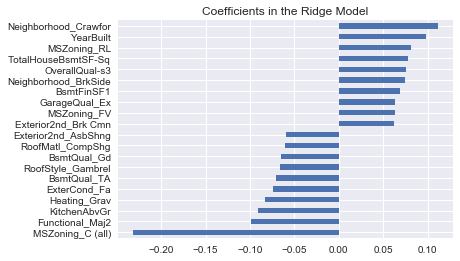

RMSE Training Data: 0.00602456240972
RMSE Testing Data: 0.00731471148394


In [26]:
#Features based on SelectFromModel(RidgeCV)
clf = RidgeCV(alphas = [.001, .01, .1, .5, .7, 1, 2], cv=10, scoring='mean_squared_error')
good_feats_ridge = SelectFromModel(clf,threshold="1.25*mean").fit(df_train_scaled,y_SalePrice)

good_feats_index_ridge = good_feats_ridge.get_support()
good_feats_columns_ridge = df_train_scaled.columns[good_feats_index_ridge]
df_train_ridge = df_train[good_feats_columns_ridge]

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_train_ridge, y_SalePrice, test_size=0.3, random_state=42)

# Scale the features
scaler2 = RobustScaler()
X_train.loc[:,:] = scaler2.fit_transform(X_train.loc[:,:])
X_test.loc[:,:] = scaler2.fit_transform(X_test.loc[:,:])

# Run RidgeCV to find best alphas
ridge = RidgeCV(alphas = [.001, .01, .1, .5, .7, 1, 2], cv=10, scoring='mean_squared_error')
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                cv = 10)
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

# Run predictions
y_train_ridge = ridge.predict(X_train)
y_test_ridge = ridge.predict(X_test)

# Plot important coefficients
coefs = pd.Series(np.ravel(ridge.coef_), index = np.ravel(df_train_ridge.columns))
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

#Show RMSE
print("RMSE Training Data:",np.sqrt(mean_squared_error(np.log1p(y_train['SalePrice']),np.log1p(y_train_ridge))))
print("RMSE Testing Data:",np.sqrt(mean_squared_error(np.log1p(y_test['SalePrice']),np.log1p(y_test_ridge))))

**LassoCV**

Best alpha : 0.0001
Try again for more precision with alphas centered around 0.0001
Best alpha : 0.00014
Lasso picked 59 features and eliminated the other 4 features


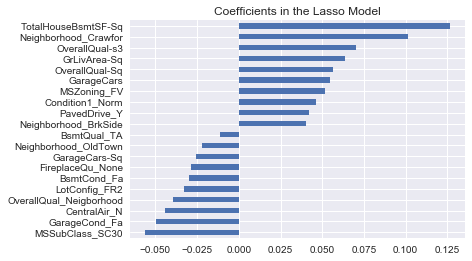

RMSE Training Data: 0.00619829793161
RMSE Testing Data: 0.0071153742319


In [27]:
#Features based on SelectFromModel(LassoCV)
clf = LassoCV(alphas = [.00001, .0001, .001, .01, .1, 1], 
                max_iter = 1000, cv = 10)
good_feats_lasso = SelectFromModel(clf,threshold="0.5*mean").fit(df_train_scaled,y_SalePrice)

good_feats_index_lasso = good_feats_lasso.get_support()
good_feats_columns_lasso = df_train_scaled.columns[good_feats_index_lasso]
df_train_lasso = df_train[good_feats_columns_lasso]

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_train_lasso, y_SalePrice, test_size=0.3, random_state=42)

# scale features
scaler2 = RobustScaler()
X_train.loc[:,:] = scaler2.fit_transform(X_train.loc[:,:])
X_test.loc[:,:] = scaler2.fit_transform(X_test.loc[:,:])

# Run LassoCV and determine best alpha
lasso = LassoCV(alphas = [.00001, .0001, .001, .01, .1, 1], 
                max_iter = 1000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)
print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

# run predictions
y_train_las = lasso.predict(X_train)
y_test_las = lasso.predict(X_test)

# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

# Show RMSE
print("RMSE Training Data:",np.sqrt(mean_squared_error(np.log1p(y_train['SalePrice']),np.log1p(y_train_las))))
print("RMSE Testing Data:",np.sqrt(mean_squared_error(np.log1p(y_test['SalePrice']),np.log1p(y_test_las))))

**HuberRegressor**

HuberRegressor picked 91 features and eliminated the other 0 features


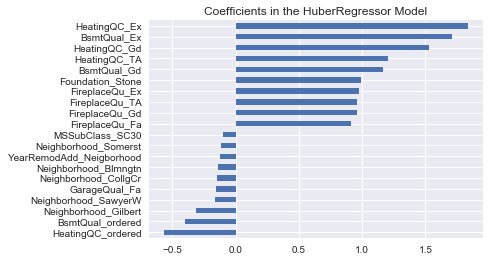

RMSE Training Data: 0.0139148378849
RMSE Testing Data: 0.0162453467774


In [28]:
#Features based on SelectFromModel(HuberRegressor)
clf = HuberRegressor(alpha=.004)
good_feats_huber = SelectFromModel(clf,threshold="1.5*mean").fit(df_train_scaled,y_SalePrice)
good_feats_index_huber = good_feats_huber.get_support()
good_feats_columns_huber = df_train_scaled.columns[good_feats_index_huber]
df_train_huber = df_train[good_feats_columns_huber]

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_train_huber, y_SalePrice, test_size=0.3, random_state=42)

# Scale the features
scaler2 = RobustScaler()
X_train.loc[:,:] = scaler2.fit_transform(X_train.loc[:,:])
X_test.loc[:,:] = scaler2.fit_transform(X_test.loc[:,:])

# Run HuberRegressor (ran some tests to find best alpha manually)
huber = HuberRegressor(alpha=.004)
huber.fit(X_train, y_train)

# Run predictions
y_train_hub = huber.predict(X_train)
y_test_hub = huber.predict(X_test)

# Plot important coefficients
coefs = pd.Series(huber.coef_, index = X_train.columns)
print("HuberRegressor picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the HuberRegressor Model")
plt.show()

# Show RSME
print("RMSE Training Data:",np.sqrt(mean_squared_error(np.log1p(y_train['SalePrice']),np.log1p(y_train_hub))))
print("RMSE Testing Data:",np.sqrt(mean_squared_error(np.log1p(y_test['SalePrice']),np.log1p(y_test_hub))))


**ElasticNetCV**

Best l1_ratio : 0.01
Best alpha : 0.001
ElasticNetCV picked 78 features and eliminated the other 0 features


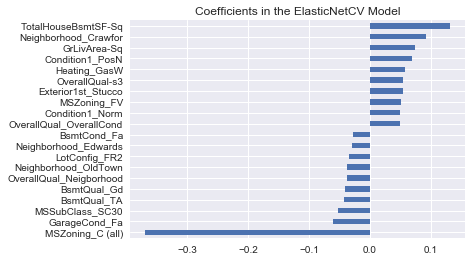

RMSE Training Data: 0.00566417345036
RMSE Testing Data: 0.00681367215772


In [29]:
#Features based on SelectFromModel(ElasticNetCV)
clf = ElasticNetCV(l1_ratio = [.01, .03, .1, .3, 0.5, 0.85, 1],
                          alphas = [.00001, .0001, .001, .01, .1, 1], 
                          max_iter = 1000, cv = 10)
good_feats_elas = SelectFromModel(clf,threshold="mean").fit(df_train_scaled,y_SalePrice)
good_feats_index_elas = good_feats_elas.get_support()
good_feats_columns_elas = df_train_scaled.columns[good_feats_index_elas]
df_train_elas = df_train[good_feats_columns_elas]

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_train_elas, y_SalePrice, test_size=0.3, random_state=42)

# scale features
scaler2 = RobustScaler()
X_train.loc[:,:] = scaler2.fit_transform(X_train.loc[:,:])
X_test.loc[:,:] = scaler2.fit_transform(X_test.loc[:,:])

# Run ElasticNetCV and determine best alpha and l1_ratio
elasticNet = ElasticNetCV(l1_ratio = [.01, .03, .1, .3, 0.5, 0.85, 1],
                          alphas = [.00001, .0001, .001, .01, .1, 1], 
                          max_iter = 1000, cv = 10)
elasticNet.fit(X_train, y_train)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

# run predictions
y_train_elas = elasticNet.predict(X_train)
y_test_elas = elasticNet.predict(X_test)

# Plot important coefficients
coefs = pd.Series(elasticNet.coef_, index = X_train.columns)
print("ElasticNetCV picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the ElasticNetCV Model")
plt.show()

# Show RMSE
print("RMSE Training Data:",np.sqrt(mean_squared_error(np.log1p(y_train['SalePrice']),np.log1p(y_train_elas))))
print("RMSE Testing Data:",np.sqrt(mean_squared_error(np.log1p(y_test['SalePrice']),np.log1p(y_test_elas))))

**BayesianRidge**

BayesianRidge picked 112 features and eliminated the other 0 features


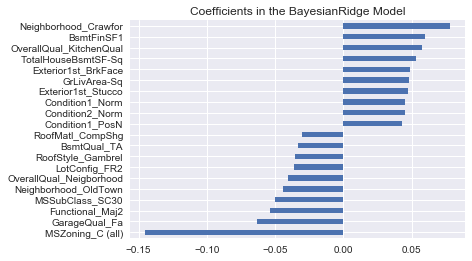

RMSE Training Data: 0.00576849318575
RMSE Testing Data: 0.00696262331159


In [30]:
#Features based on SelectFromModel(BayesianRidge)
clf = BayesianRidge(n_iter=1000)
good_feats_bayes = SelectFromModel(clf,threshold="1.25*mean").fit(df_train_scaled,y_SalePrice)
good_feats_index_bayes = good_feats_bayes.get_support()
good_feats_columns_bayes = df_train_scaled.columns[good_feats_index_bayes]
df_train_bayes = df_train[good_feats_columns_bayes]

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_train_bayes, y_SalePrice, test_size=0.3, random_state=42)

# Scale the features
scaler2 = RobustScaler()
X_train.loc[:,:] = scaler2.fit_transform(X_train.loc[:,:])
X_test.loc[:,:] = scaler2.fit_transform(X_test.loc[:,:])

# Run BayesianRidge (ran some tests to find best alpha - default is ok)
bayes = BayesianRidge(n_iter=1000)
bayes.fit(X_train, y_train)

# Run predictions
y_train_bay = bayes.predict(X_train)
y_test_bay = bayes.predict(X_test)

# Plot important coefficients
coefs = pd.Series(bayes.coef_, index = df_train_bayes.columns)
print("BayesianRidge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the BayesianRidge Model")
plt.show()

# Show RSME
print("RMSE Training Data:",np.sqrt(mean_squared_error(np.log1p(y_train['SalePrice']),np.log1p(y_train_bay))))
print("RMSE Testing Data:",np.sqrt(mean_squared_error(np.log1p(y_test['SalePrice']),np.log1p(y_test_bay))))


**RandomForestRegressor**


RandomForestRegressor picked 97 features and eliminated the other 0 features


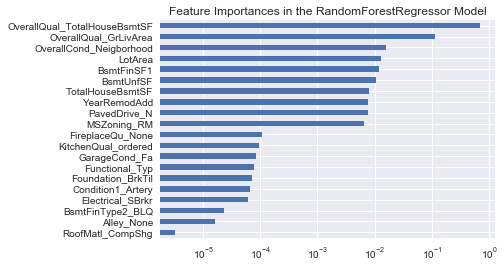

RMSE Training Data: 0.00386198874238
RMSE Testing Data: 0.0101221778623


In [31]:
#Features based on SelectFromModel(RandomForestRegressor)
clf = RandomForestRegressor(n_estimators=20)
good_feats_rfr = SelectFromModel(clf,threshold=".1*mean").fit(df_train_scaled,y_SalePrice)
good_feats_index_rfr = good_feats_rfr.get_support()
good_feats_columns_rfr = df_train_scaled.columns[good_feats_index_rfr]
df_train_rfr = df_train[good_feats_columns_rfr]

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_train_rfr, y_SalePrice, test_size=0.3, random_state=42)

# Scale the features
scaler2 = RobustScaler()
X_train.loc[:,:] = scaler2.fit_transform(X_train.loc[:,:])
X_test.loc[:,:] = scaler2.fit_transform(X_test.loc[:,:])

# Run BayesianRidge (ran some tests to find best alpha - default is ok)
rfr = RandomForestRegressor(n_estimators=20)
rfr.fit(X_train, y_train)

# Run predictions
y_train_rfr = rfr.predict(X_train)
y_test_rfr = rfr.predict(X_test)

# Plot important coefficients
coefs = pd.Series(rfr.feature_importances_, index = df_train_rfr.columns)
print("RandomForestRegressor picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
coefs = coefs[coefs !=0]
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Feature Importances in the RandomForestRegressor Model")
plt.xscale('log')
plt.show()

# Show RSME
print("RMSE Training Data:",np.sqrt(mean_squared_error(np.log1p(y_train['SalePrice']),np.log1p(y_train_rfr))))
print("RMSE Testing Data:",np.sqrt(mean_squared_error(np.log1p(y_test['SalePrice']),np.log1p(y_test_rfr))))


# Predictions from each model

**Ridge**

In [32]:
# Get right features
df_test_ridge = df_test.loc[:,df_test.columns.isin(good_feats_columns_ridge)]
# Scale the features
scaler2 = RobustScaler()
df_test_ridge.loc[:,:] = scaler2.fit_transform(df_test_ridge.loc[:,:])
# Predict
test_ridge = ridge.predict(df_test_ridge)
test_ridge = pd.DataFrame(test_ridge, index=df_test['Id'], columns=['SalePrice'])
# Get real prices and save to csv
test_ridge = np.expm1(test_ridge)
test_ridge.to_csv('test_ridge.csv', index_label='Id')

**Lasso**

In [33]:
# Get right features
df_test_lasso = df_test[good_feats_columns_lasso]
# Scale the features
scaler2 = RobustScaler()
df_test_lasso.loc[:,:] = scaler2.fit_transform(df_test_lasso.loc[:,:])
# Predict
test_lasso = lasso.predict(df_test_lasso)
test_lasso = pd.DataFrame(test_lasso, index=df_test['Id'], columns=['SalePrice'])
# Get real prices and save to csv
test_lasso = np.expm1(test_lasso)
test_lasso.to_csv('test_lasso.csv', index_label='Id')

**HuberRegression**

For some reason the "real" prices are nowhere near right. Not sure whats going on here

In [34]:
# Get right features
df_test_huber = df_test[good_feats_columns_huber]
# Scale the features
scaler2 = RobustScaler()
df_test_huber.loc[:,:] = scaler2.fit_transform(df_test_huber.loc[:,:])
# Predict
test_huber = huber.predict(df_test_huber)
test_huber = pd.DataFrame(test_huber, index=df_test['Id'], columns=['SalePrice'])
# Get real prices and save to csv
test_huber = np.expm1(test_huber)
test_huber.to_csv('test_huber.csv', index_label='Id')

**ElasticNet**

In [35]:
# Get right features
df_test_elas = df_test[good_feats_columns_elas]
# Scale the features
scaler2 = RobustScaler()
df_test_elas.loc[:,:] = scaler2.fit_transform(df_test_elas.loc[:,:])
# Predict
test_elas = elasticNet.predict(df_test_elas)
test_elas = pd.DataFrame(test_elas, index=df_test['Id'], columns=['SalePrice'])
# Get real prices and save to csv
test_elas = np.expm1(test_elas)
test_elas.to_csv('test_elas.csv', index_label='Id')

**BayesianRidge**

In [36]:
# Get right features
df_test_bayes = df_test[good_feats_columns_bayes]
# Scale the features
scaler2 = RobustScaler()
df_test_bayes.loc[:,:] = scaler2.fit_transform(df_test_bayes.loc[:,:])
# Predict
test_bayes = bayes.predict(df_test_bayes)
test_bayes = pd.DataFrame(test_bayes, index=df_test['Id'], columns=['SalePrice'])
# Get real prices and save to csv
test_bayes = np.expm1(test_bayes)
test_bayes.to_csv('test_bayes.csv', index_label='Id')

**RandomForestsRegressor**

In [37]:
# Get right features
df_test_rfr = df_test[good_feats_columns_rfr]
# Scale the features
scaler2 = RobustScaler()
df_test_rfr.loc[:,:] = scaler2.fit_transform(df_test_rfr.loc[:,:])
# Predict
test_rfr = rfr.predict(df_test_rfr)
test_rfr = pd.DataFrame(test_rfr, index=df_test['Id'], columns=['SalePrice'])
# Get real prices and save to csv
test_rfr = np.expm1(test_rfr)
test_rfr.to_csv('test_rfr.csv', index_label='Id')

**Mean of all models**

In [38]:
mean_model = pd.concat([test_bayes, test_elas, test_ridge, test_lasso, test_rfr], axis=1)
mean_model = mean_model.mean(axis=1)
test_mean = pd.DataFrame(mean_model, index=df_test['Id'], columns=['SalePrice'])
test_mean.to_csv('test_mean.csv', index_label='Id')

In [40]:
# mean of both lasso and bayes seems to work best
mean_model = pd.concat([test_bayes, test_lasso], axis=1)
mean_model = mean_model.mean(axis=1)
test_mean = pd.DataFrame(mean_model, index=df_test['Id'], columns=['SalePrice'])
test_mean.to_csv('test_mean_bayes_lasso.csv', index_label='Id')